In [2]:
from scipy.interpolate import interp1d
from specutils import Spectrum1D
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from specutils.manipulation import FluxConservingResampler
from pybaselines import whittaker
import numpy as np
import matplotlib.pyplot as plt
import pickle
import astropy.units as u
from astropy.io import fits
import scipy.constants as cst
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.cosmology import Planck15 as cosmo
from functools import partial
import powspec
import pandas as pd
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.modeling.models import Gaussian1D
from scipy.interpolate import interp1d
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.markers as mmarkers
from analysis_fcts.set_k import make_bintab

noise_model_HF = pd.read_csv('tim_sw_loading.tsv', sep='\t')
noise_model_LF = pd.read_csv('tim_lw_loading.tsv', sep='\t')

redshift depth at z=1.48 dz= 0.3442402426502489
redshift depth at z=1.16 dz= 0.29906571500860624
redshift depth at z=0.88 dz= 0.25715678875641257
redshift depth at z=0.63 dz= 0.22375563534714393


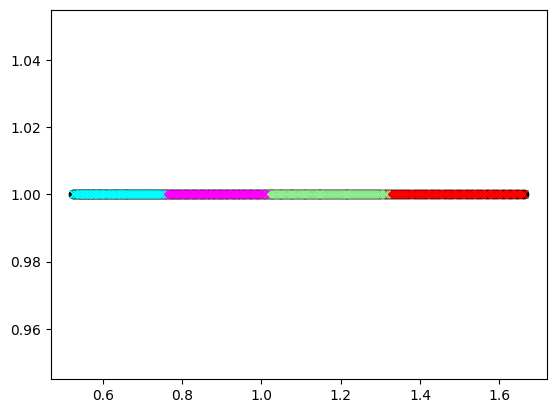

In [10]:
#TIM params
lambda_HF = noise_model_HF["# Wavelength[um]"]*1e3 #nm
nu_HF = cst.c/(lambda_HF*1e-9)/1e9 #GHz
lambda_LF = noise_model_LF["# Wavelength[um]"]*1e3 #nm
nu_LF = cst.c/(lambda_LF*1e-9)/1e9 #GHz
freqs_tim = np.concatenate((nu_LF[::-1], nu_HF[::-1]))
lambda_tim = np.concatenate((lambda_LF, lambda_HF))
nHF = noise_model_HF["NEI[Jy/sr s^1/2]"]
nLF = noise_model_LF["NEI[Jy/sr s^1/2]"]
noise = (np.concatenate((nLF[::-1], nHF[::-1]))*u.Jy/u.sr).to(u.MJy/u.sr)
zcii_tim = 1900.53690000 / (freqs_tim) -1

z_bins_center = []
z_bins_index = []
z_binswidth_index = []

for i, nu_list in enumerate((nu_HF, nu_LF)):
    
    inu_mid = int(len(nu_list)//2)
    izmid_low = inu_mid//2
    izmid_high = inu_mid//2+inu_mid
    if(i==1):
        izmid_low+=len(nu_HF)
        izmid_high+=len(nu_HF)

    z_bins_index.append(izmid_low)
    z_bins_index.append(izmid_high)
    z_bins_center.append(zcii_tim[izmid_low])
    z_bins_center.append(zcii_tim[izmid_high])
    z_binswidth_index.append(inu_mid//2)
    z_binswidth_index.append(inu_mid//2)

plt.plot( zcii_tim, np.ones(zcii_tim.shape), 'ok')
for z, iz, idz, c in zip(z_bins_center, z_bins_index, z_binswidth_index, ('r', 'lightgreen', 'magenta', 'cyan')):
    plt.plot(zcii_tim[int(iz-idz):int(iz+idz)+1], np.ones(zcii_tim[int(iz-idz):int(iz+idz)+1].shape), 'x', c=c)
    print(f'redshift depth at z={np.round(z,2)} dz=', zcii_tim[int(iz-idz)]-zcii_tim[int(iz+idz)] )
#before z_bins_center = (0.64, 0.9, 1.18, 1.5)



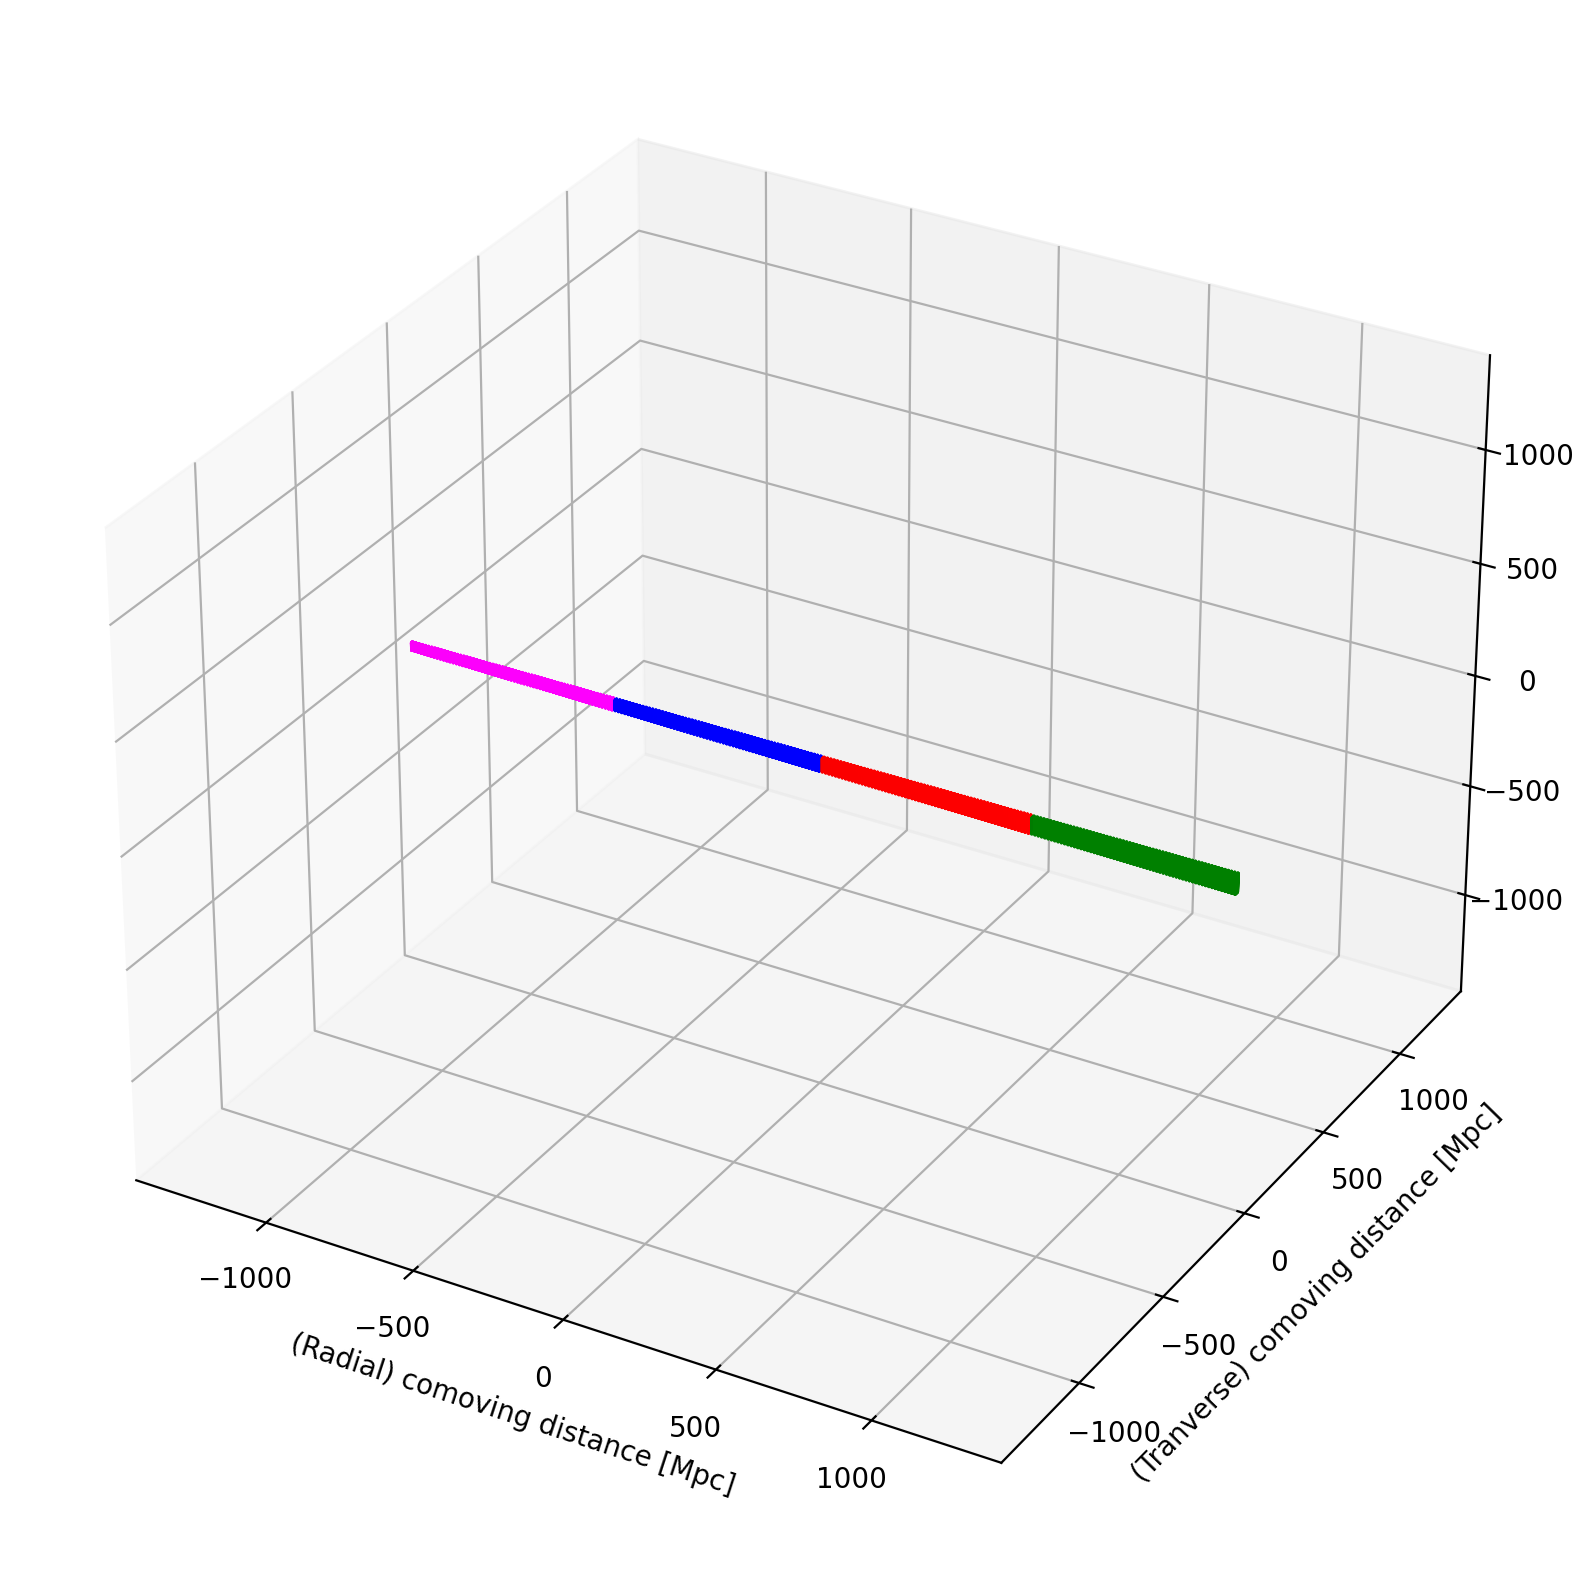

In [11]:
#Spatial deep
res = 45 #arcsec
field_size_ra =  0.2 
field_size_dec = 1 

field_size = (field_size_ra *field_size_dec)*u.deg**2
ragrid= np.arange(0,field_size_ra,(res*u.arcsec).to(u.deg).value)
decgrid= np.arange(0,field_size_dec,(res*u.arcsec).to(u.deg).value)

ra_center = np.mean(ragrid)
dec_center = np.mean(decgrid)
delta_ra = np.max(ragrid) - np.min(ragrid)
delta_dec = np.max(decgrid) - np.min(decgrid)

Dc_center = cosmo.comoving_distance(zcii_tim).value

#all the coordinates will be in comoving units
size_x = Dc_center * delta_ra * (np.pi/180) * np.cos(np.pi/180*dec_center)
size_y = Dc_center * delta_dec * (np.pi/180) 

#compute the coordinates in the cube
ys = Dc_center * ( ragrid[:, np.newaxis]  - ra_center)  * (np.pi/180) * np.cos(np.pi/180*ragrid[:, np.newaxis])
xs = Dc_center * ( decgrid[:, np.newaxis] - dec_center) * (np.pi/180)

#box_size = np.min([size_x, size_y])
#bins = np.linspace(-box_size/2, box_size/2, num = Nvox + 1)

grid=np.array(np.meshgrid(ys,xs))
cube = np.zeros((len(zcii_tim), len(ragrid), len(decgrid), 3))
for i,c in zip(range(len(zcii_tim)), cm.plasma(np.linspace(0,1,len(zcii_tim)))):
    for j in range(len(ragrid)):
        for k in range(len(decgrid)):
            cube[i,j,k,0] = Dc_center[i]
            cube[i,j,k,1] = ys[j, i]
            cube[i,j,k,2] = xs[k, i]

ax = plt.figure(figsize=(8,8), dpi=200).add_subplot(projection='3d')
dc_center = cube[int(cube.shape[0]/2),int(cube.shape[1]/2),int(cube.shape[2]/2),0]
centered_cube = cube.copy()
centered_cube[:,:,:,0] -= dc_center

for iz, idz, c in zip(z_bins_index, z_binswidth_index, ('g', 'r',  'b', 'magenta')):
    subcube = centered_cube[int(iz-idz):int(iz+idz+1),:,:,:]
    ax.scatter(subcube[:,:,:,0].flatten(), subcube[:,:,:,1].flatten(), subcube[:,:,:,2].flatten(), marker='.', s=0.1,c=c)
ax.set_xlabel("(Radial) comoving distance [Mpc]")
ax.set_ylabel("(Tranverse) comoving distance [Mpc]")
#ax.set_zlabel("comoving distance [Mpc]")
ax.set_xlim([centered_cube[:,:,:,0].min(), centered_cube[:,:,:,0].max()])  # Example limits for x-axis
ax.set_ylim([centered_cube[:,:,:,0].min(), centered_cube[:,:,:,0].max()])  # Example limits for y-axis
ax.set_zlim([centered_cube[:,:,:,0].min(), centered_cube[:,:,:,0].max()])  # Example limits for z-axis
plt.tight_layout()


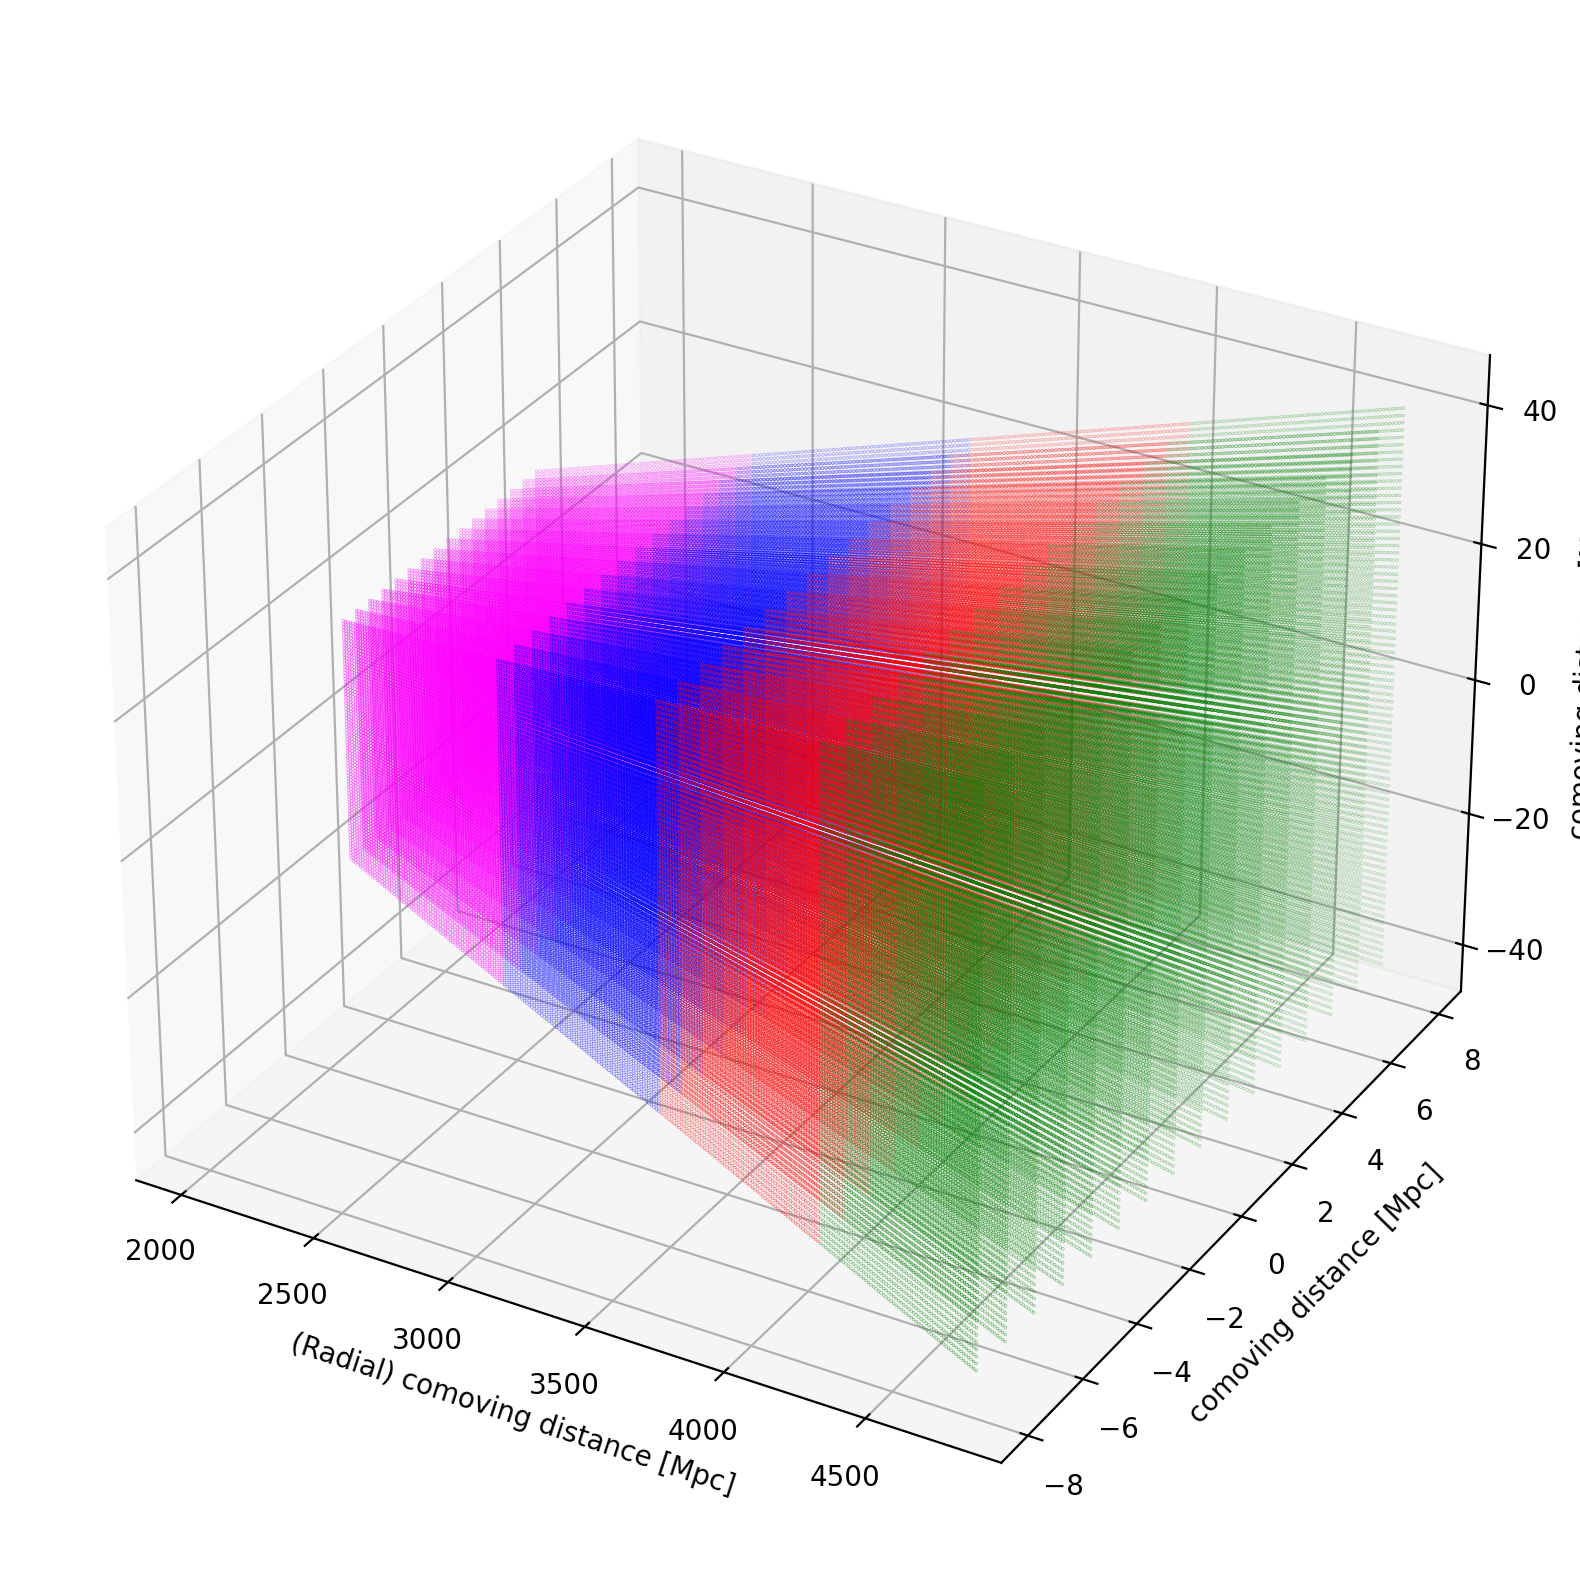

In [12]:
ax = plt.figure(figsize=(8,8), dpi=200).add_subplot(projection='3d')

for iz, idz, c in zip(z_bins_index, z_binswidth_index, ('g', 'r',  'b', 'magenta')):
    subcube = cube[int(iz-idz):int(iz+idz+1),:,:,:]
    ax.scatter(subcube[:,:,:,0].flatten(), subcube[:,:,:,1].flatten(), subcube[:,:,:,2].flatten(), marker='.', s=0.1,c=c)
ax.set_xlabel("(Radial) comoving distance [Mpc]")
ax.set_ylabel("comoving distance [Mpc]")
ax.set_zlabel("comoving distance [Mpc]")
plt.tight_layout()


length [Mpc]: 652.9564296093413
diff at high z in %: -13.680915086089826
radial res: 10.303895542176178
diff at high z in %: -204.29281912168096
diagonal: 82.2590192492503
spatial res: 1.0412535692883198
diff at high z in %: -13.680915086089755


length [Mpc]: 678.1590986509891
diff at high z in %: -16.504056797669577
radial res: 10.759253907802304
diff at high z in %: -203.1321108180088
diagonal: 70.81990751158516
spatial res: 0.896454664134338
diff at high z in %: -16.504056797669563


length [Mpc]: 687.3538354039792
diff at high z in %: -20.099328265698304
radial res: 10.983046592185474
diff at high z in %: -201.63055259745573
diagonal: 58.940428520703584
spatial res: 0.7460814890900256
diff at high z in %: -20.099328265698432


length [Mpc]: 692.8239528465153
diff at high z in %: -25.459603164890325
radial res: 11.165024266546425
diff at high z in %: -199.8712648010454
diagonal: 46.90139236497366
spatial res: 0.5936886027858379
diff at high z in %: -25.459603164890254



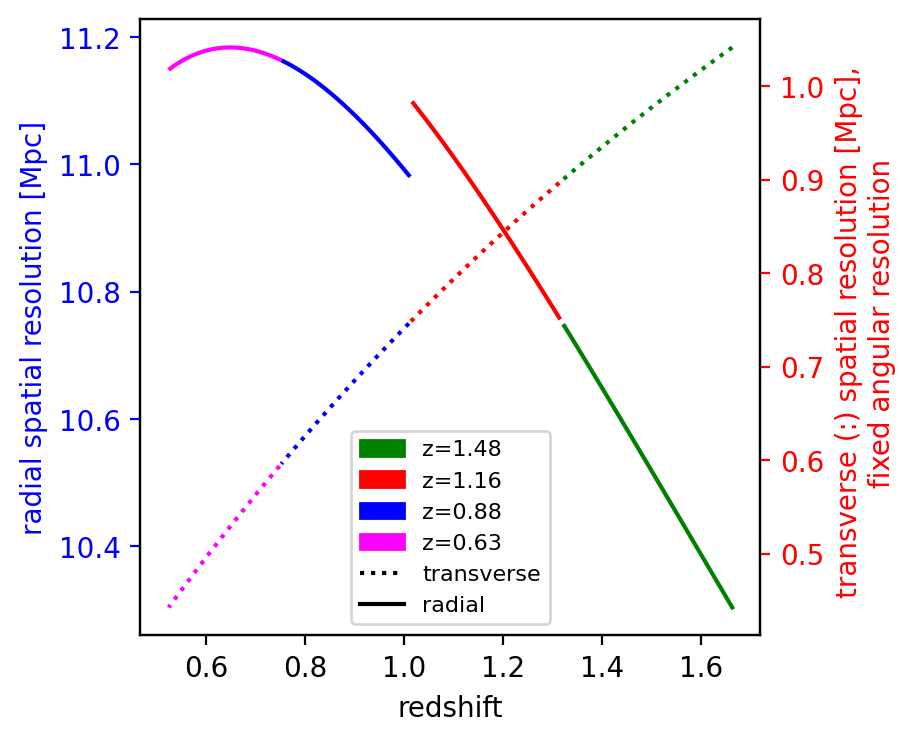

In [14]:

BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, ax = plt.subplots(figsize=(4,4), dpi=200) 
ax2 = ax.twinx()
patchs = []

for iz, idz, c in zip(z_bins_index, z_binswidth_index, ('g', 'r',  'b', 'magenta')):

    patch = mpatches.Patch(color=c, label=f'z={np.round(zcii_tim[iz],2)}' ); patchs.append(patch); 
    subcube = cube[int(iz-idz):int(iz+idz+1),:,:,:]
    Dc_center = cube[iz,0,0,0]
    subcube[:,:,:,0] -= Dc_center
    ax.plot(zcii_tim[int(iz-idz):int(iz+idz+1)][:-1], -subcube[1:, 0, 0,0]+subcube[:-1, 0, 0,0], c=c)
    ax2.plot(zcii_tim[int(iz-idz):int(iz+idz+1)], subcube[:, 1, 0,1]-subcube[:, 0, 0, 1], c=c, ls=':')
    
    print('')
    ###
    print('length [Mpc]:', subcube[:,0,0,0].max() - subcube[:,0,0,0].min())
    print('diff at high z in %:', 100*(subcube[-1, :, :,2].max() - subcube[-1, :, :,2].min())/(subcube[0, :, :,2].max() - subcube[0, :, :,2].min())-100)
    print('radial res:', subcube[0, 0, 0,0]-subcube[1, 0, 0,0])
    print('diff at high z in %:', 100*((subcube[-1, 0, 0,0]-subcube[-2, 0, 0,0]) / np.abs(subcube[0, 0, 0,0]-subcube[1, 0, 0,0]))-100  )
    ###
    print('diagonal:', subcube[0, :, :,2].max() - subcube[0, :, :,2].min()  )
    print('spatial res:', subcube[0, 1, 0,1]-subcube[0, 0, 0, 1])
    print('diff at high z in %:', np.abs(100*(subcube[-1, 1, 0,1]-subcube[-1, 0, 0, 1]) / (subcube[0, 1, 0,1]-subcube[0, 0, 0, 1])) -100)
    print('')

patch = mlines.Line2D([], [], color='k', linestyle=":",  label='transverse'); patchs.append(patch)
patch = mlines.Line2D([], [], color='k', linestyle="solid",  label='radial'); patchs.append(patch)

#neglecting the small variation with redshift
ax.set_ylabel('radial spatial resolution [Mpc]', color='b')
ax.tick_params('y', colors='blue')
ax2.set_ylabel('transverse (:) spatial resolution [Mpc], \n fixed angular resolution', color='r')
ax2.tick_params('y', colors='r')
ax.set_xlabel('redshift')
ax.legend(handles = patchs, loc='lower center',  fontsize=8)#bbox_to_anchor=(1.5, 1),



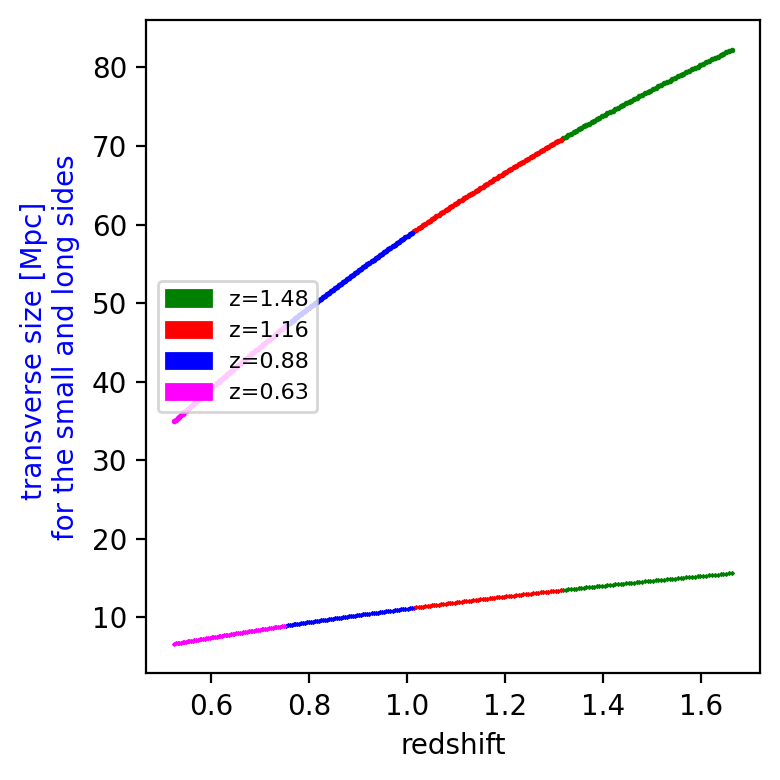

In [16]:

BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, ax = plt.subplots(figsize=(4,4), dpi=200) 
patchs = []

for iz, idz, c in zip(z_bins_index, z_binswidth_index, ('g', 'r',  'b', 'magenta')):

    subcube = cube[int(iz-idz):int(iz+idz+1),:,:,:]
    Dc_center = cube[iz,0,0,0]
    subcube[:,:,:,0] -= Dc_center
    patch = mpatches.Patch(color=c, label=f'z={np.round(zcii_tim[iz],2)}' ); patchs.append(patch); 

    print('')
    ###
    for j,z in zip(np.arange(subcube.shape[0]),zcii_tim[int(iz-idz):int(iz+idz+1)]): # 
        diamA = subcube[j, :, :,2].max() - subcube[j, :, :,2].min()
        diamB = subcube[j, :, :,1].max() - subcube[j, :, :,1].min()

        ax.plot(z, diamA, 'o', c=c, markersize=1) 
        ax.plot(z, diamB, 'x', c=c, markersize=1) 

ax.set_ylabel('transverse size [Mpc] \nfor the small and long sides', color='b')
ax.legend(handles = patchs, loc = 'center left', fontsize=8)
ax.set_xlabel('redshift')
fig.tight_layout()


In [17]:
def give_map_spatial_freq(res, ny, nx):
    Ys, Xs = np.unravel_index(np.arange(nx*ny),(ny,nx))
    N = np.zeros((ny, nx))
    M = np.zeros((ny, nx))
    for  xs, ys, in zip(Xs, Ys):
        N[ys,xs] = int(xs)
        M[ys,xs] = int(ys)
    w_sup = np.where(M>ny/2)
    M[w_sup] = ny - M[w_sup]
    w_sup = np.where(N>nx/2)
    N[w_sup] = nx - N[w_sup]
    Kx = N/nx/res
    Ky = M/ny/res
    k_map = (Kx**2 + Ky**2)**(1/2)
    return k_map

def give_map_spatial_freq_one_axis(res, ny):
    Ys = np.arange(ny)
    M = np.zeros(ny)
    for ys, in zip(Ys):
        M[ys] = int(ys)
    w_sup = np.where(M>ny/2)
    M[w_sup] = ny - M[w_sup]
    Ky = M/ny/res
    k_map = (Ky**2)**(1/2)
    return k_map

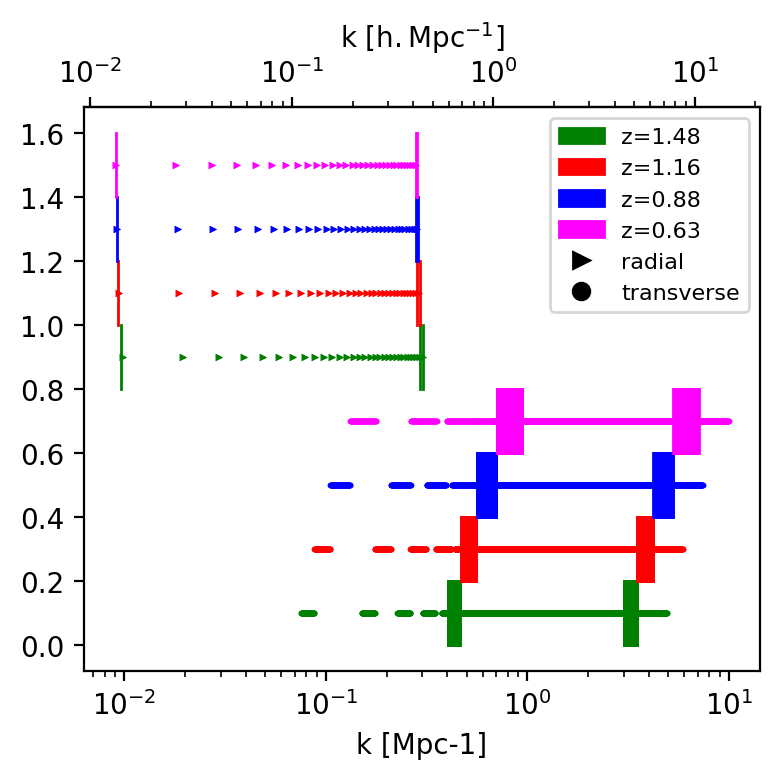

In [18]:
BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, ax = plt.subplots(figsize=(4,4), dpi=200) 
patchs = []

for I, (iz, idz, c) in enumerate(zip(z_bins_index, z_binswidth_index, ('g', 'r',  'b', 'magenta'))):

    subcube = cube[int(iz-idz):int(iz+idz+1),:,:,:]
    Dc_center = cube[iz,0,0,0]
    subcube[:,:,:,0] -= Dc_center
    patch = mpatches.Patch(color=c, label=f'z={np.round(zcii_tim[iz],2)}' ); patchs.append(patch); 
    y= 0.1 + 0.2*I

    for zii in range(len(subcube[:,0,0,1])):
        r_cylindrical = np.sqrt(subcube[zii,:,:,1]**2+subcube[zii,:,:,2]**2)
        res = subcube[zii, 1, 0,1]-subcube[zii, 0, 0, 1]
        diameter = r_cylindrical[0,r_cylindrical.shape[1]//2]*2
        ax.plot((2 * np.pi / diameter, 2 * np.pi / diameter), (y-0.1,y+0.1), c=c,lw=1)
        ax.plot((np.pi / res,  np.pi / res), (y-0.1,y+0.1), c=c,lw=1)
        kmap = give_map_spatial_freq(res, r_cylindrical.shape[0], r_cylindrical.shape[1])
        ax.plot(2*np.pi*kmap.flatten(), y*np.ones(len(kmap.flatten())), 'o', c=c, markersize=1)
    
    y+=0.8
    z = np.abs(subcube[:,0,0,0])
    lenght = z[0]+z[-1]
    res = z[0]-z[1]
    res_highz = np.abs(z[-2]-z[-1])
    kz = give_map_spatial_freq_one_axis(res, len(z))
    ax.plot(2*np.pi*kz, y*np.ones(len(kz)), '>', c=c, markersize=1)
    ax.plot((2 * np.pi / lenght, 2 * np.pi / lenght), (y-0.1,y+0.1), c=c,lw=1)
    ax.plot((np.pi / res,  np.pi / res), (y-0.1,y+0.1), c=c,lw=1)
    ax.plot((np.pi / res_highz,  np.pi / res_highz), (y-0.1,y+0.1), c=c,lw=1)
    


patch = mlines.Line2D([], [], color='k', linestyle='None', marker = '>',label='radial'); patchs.append(patch)
patch = mlines.Line2D([], [], color='k', linestyle='None', marker = 'o',label='transverse'); patchs.append(patch)
ax.set_xscale('log')
ax.set_xlabel('k [Mpc-1]')

def g(h, x): return x/h
G = partial(g, cosmo.h)
secax = ax.secondary_xaxis("top", functions=(G,G))
secax.set_xlabel('k [$\\rm h.Mpc^{-1}$]')
#patch = mlines.Line2D([], [], color='k', linestyle='solid', label='at high-z'); patchs.append(patch)
ax.legend(handles = patchs, loc='upper right',  fontsize=8)#bbox_to_anchor=(1.5, 1),
fig.tight_layout()



/home/mvancuyck/anaconda3/envs/camb/lib/python3.9/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


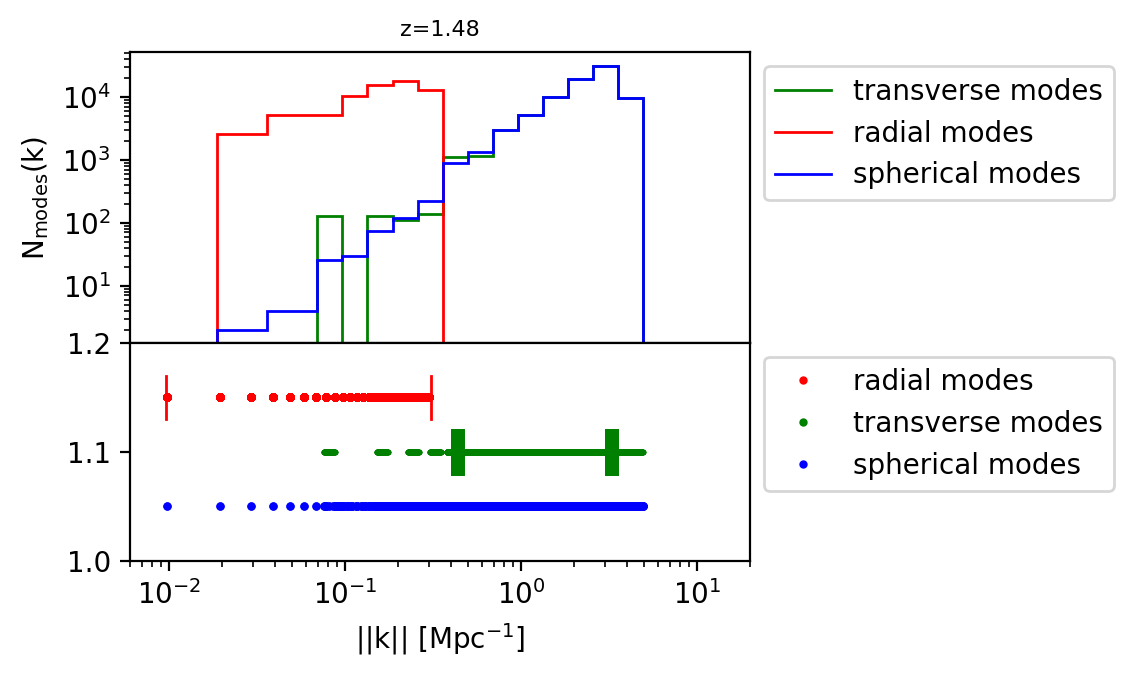

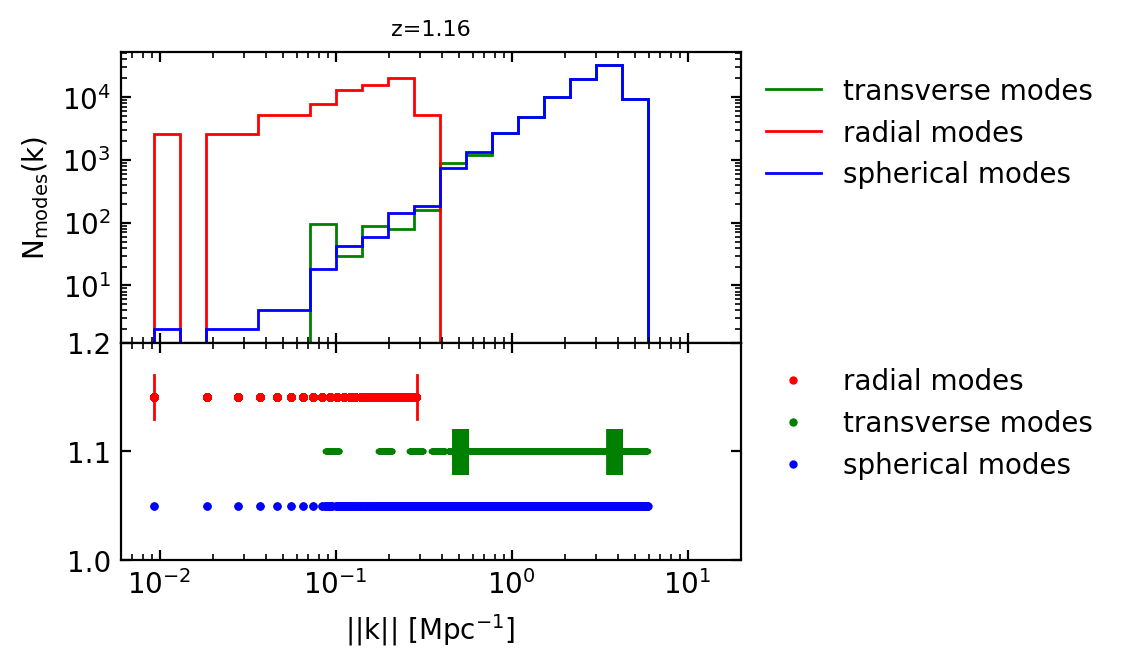

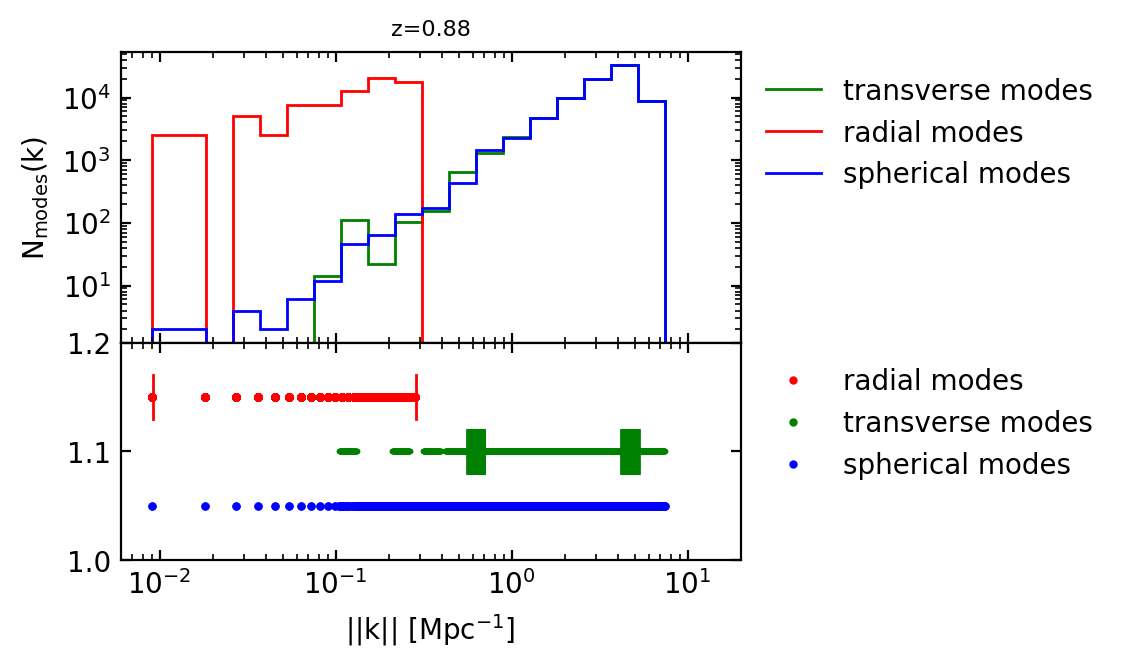

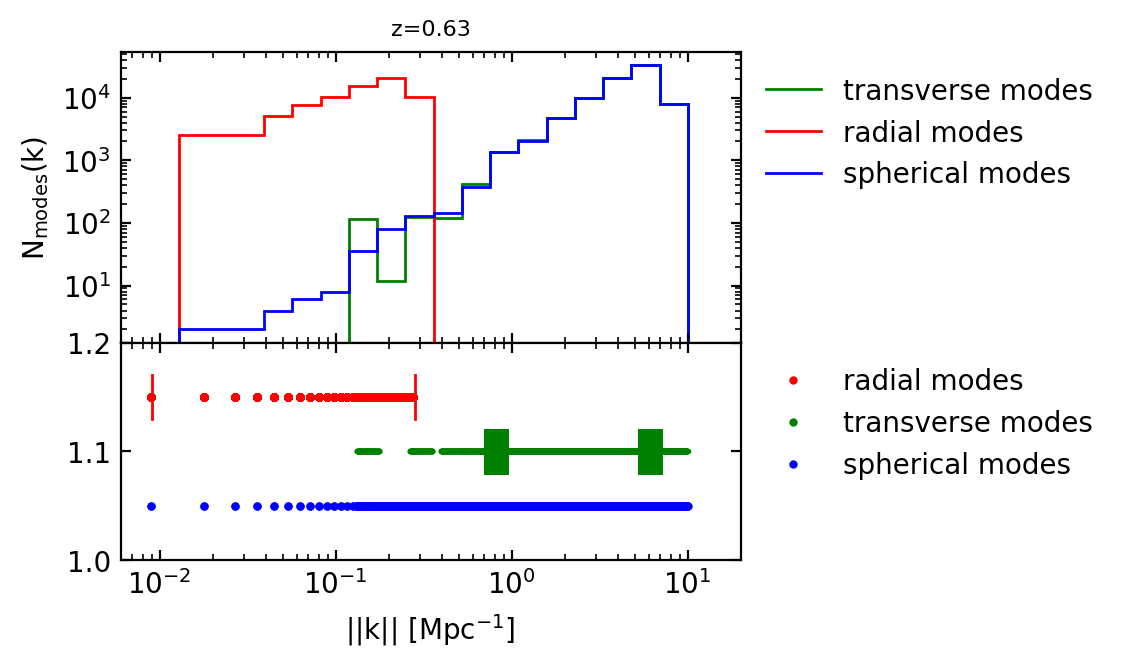

In [19]:


for I, (iz, idz, c) in enumerate(zip(z_bins_index, z_binswidth_index, ('g', 'r',  'b', 'magenta'))):

    BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
    fig, (ax, viz) = plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,3]}, 
                                 figsize=(4, 3.3), dpi = 200)
    #patchs = []
    #patch = mpatches.Patch(color=c, label=f'z={np.round(zcii_tim[iz],2)}' ); patchs.append(patch);

    subcube = cube[int(iz-idz):int(iz+idz+1),:,:,:]
    Dc_center = cube[iz,0,0,0]
    subcube[:,:,:,0] -= Dc_center
    kmaps_list = []
    kmaps_nyquist = []
    kperp_min_list = []
    kperp_max_list = []
    for zii in range(len(subcube[:,0,0,1])):
        r_cylindrical = np.sqrt(subcube[zii,:,:,1]**2+subcube[zii,:,:,2]**2)
        res = subcube[zii, 1, 0,1]-subcube[zii, 0, 0, 1]
        if(zii==0): res_perp_0 = res
        diameter = r_cylindrical[0,r_cylindrical.shape[1]//2]*2

        kmap = give_map_spatial_freq(res, r_cylindrical.shape[0], r_cylindrical.shape[1])
        kperp_min_list.append(2 * np.pi / diameter)
        kperp_max_list.append(np.pi / res)
        kmap = 2*np.pi*give_map_spatial_freq(res, r_cylindrical.shape[1], r_cylindrical.shape[0])
        kmaps_list.append(kmap)
        viz.plot((2 * np.pi / diameter, 2 * np.pi / diameter), (1.1-0.02,1.1+0.02), c='g',lw=1)
        viz.plot((np.pi / res,  np.pi / res), (1.1-0.02,1.1+0.02), c='g',lw=1)
        viz.plot(kmap.flatten(), 1.1*np.ones(len(kmap.flatten())), 'o', c='g', markersize=1)

    z = np.abs(subcube[:,0,0,0])
    lenght = z[0]+z[-1]
    res = z[0]-z[1]
    res_highz = np.abs(z[-2]-z[-1])
    k_pll_min = 2 * np.pi / lenght
    k_pll_max_lowz = np.pi / res
    kz = 2*np.pi*give_map_spatial_freq_one_axis(res, len(z))
    viz.plot(kz, y*np.ones(len(kz)), '>', c='r', markersize=1)
    viz.plot((2 * np.pi / lenght, 2 * np.pi / lenght), (1.15-0.02,1.15+0.02), c='r',lw=1)
    viz.plot((np.pi / res,  np.pi / res), (1.15-0.02,1.15+0.02), c='r',lw=1)

    kz_arr = np.zeros(np.asarray(kmaps_list).shape)
    kz_arr[:,:,:] = kz[:,np.newaxis, np.newaxis]

    k = np.sqrt(np.asarray(kmaps_list)**2+kz[:,np.newaxis, np.newaxis]**2)/u.Mpc
    #Setting the binning of the k map
    k_binsnp = np.logspace(np.log10(k[k>0].min().value), np.log10(k.max().value), 20)

    nmodes, kbins = np.histogram(np.asarray(kmaps_list).flatten(), bins = k_binsnp)
    ax.stairs(nmodes,k_binsnp, color='g', label='transverse modes')
    nmodes, kbins = np.histogram(np.asarray(kz_arr).flatten(), bins = k_binsnp)
    ax.stairs(nmodes,k_binsnp, color='r', label='radial modes')
    nmodes, kbins = np.histogram(k, bins = k_binsnp/u.Mpc)
    kmean, kbins = np.histogram(k, bins = k_binsnp/u.Mpc, weights=k)
    kmean /= nmodes
    ax.stairs(nmodes,k_binsnp, color='b', label='spherical modes')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('$\\rm N_{modes}(k)$')
    ax.set_title(f'z={np.round(zcii_tim[iz],2)}',fontsize=8)
    ax.legend(bbox_to_anchor=(1, 1),)
        
    viz.loglog(kz_arr.flatten(), 1.15*np.ones(kz_arr.flatten().shape), 'or', markersize=2, label='radial modes')
    viz.loglog(np.asarray(kmaps_nyquist).flatten(), 1.1*np.ones(np.asarray(kmaps_nyquist).flatten().shape), 'og', markersize=2, label='transverse modes')
    viz.loglog(k.flatten(), 1.05*np.ones(k.flatten().shape), 'ob', markersize=2, label='spherical modes')
    viz.set_xlabel(r'$\rm ||k||$ [$\rm Mpc^{-1}$]')
    viz.set_ylim(1, 1.2)
    viz.set_yscale('linear')
    viz.legend(bbox_to_anchor=(1, 1),)
    viz.set_xlim(6e-3, 2e1)

    fig.subplots_adjust(hspace=0, wspace=0)
    plt.rcParams.update({'font.size': 10})
    plt.rcParams.update({'xtick.direction':'in'})
    plt.rcParams.update({'ytick.direction':'in'})
    plt.rcParams.update({'xtick.top':True})
    plt.rcParams.update({'ytick.right':True})
    plt.rcParams.update({'legend.frameon':False})



[            nan             nan -9.72895126e-01 -9.15323112e-01
 -8.67732731e-01 -6.16832165e-01 -8.48940190e-01 -6.77594506e-01
 -6.21506782e-01 -3.84363953e-01 -1.42258661e-01 -3.83674231e-01
 -9.72999178e-03  3.05765832e-01  1.01023240e+00  1.71844916e+00
  2.71714200e+00  4.85939236e+00  4.26673596e+01]
[-9.97593974e-01             nan -9.80999177e-01 -9.39929540e-01
 -9.05044634e-01 -7.21626927e-01 -8.08477949e-01 -7.95573555e-01
 -5.76587835e-01 -5.18589247e-01  7.56664063e-04 -2.04090981e-01
  5.31420213e-02  6.02872307e-01  1.39493570e+00  2.16858547e+00
  3.53158015e+00  6.27236607e+00  5.74981871e+01]
[-9.98401697e-01 -9.90898801e-01             nan -9.71757453e-01
 -8.35896684e-01 -8.47372865e-01 -7.38967811e-01 -8.26917247e-01
 -6.37289706e-01 -5.33974587e-01  1.01080378e-01  3.57990832e-01
  1.58069535e-04  1.09475300e+00  1.77182680e+00  2.86811269e+00
  4.56301984e+00  8.32317458e+00  8.20855461e+01]
[         nan  -0.99439539  -0.98174874  -0.95303922  -0.93574962
  -0

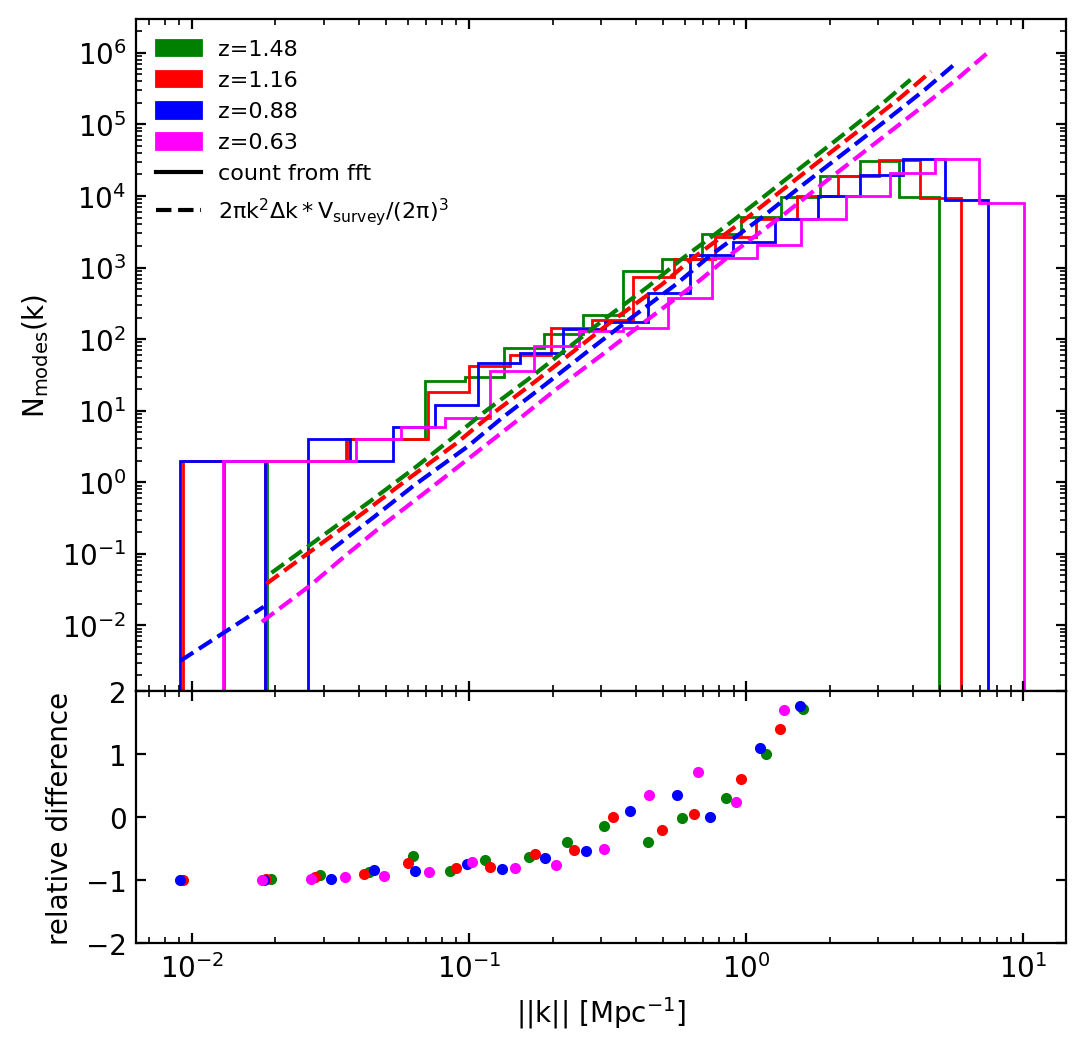

In [23]:
BS = 10; plt.rc('font', size=BS); plt.rc('axes', titlesize=BS); plt.rc('axes', labelsize=BS); mk = 3; lw=1
fig, (ax, axr) =  plt.subplots(2, 1, sharex=True, sharey = 'row', gridspec_kw={'height_ratios': [4,1.5]}, 
                                 figsize=(6,6), dpi = 200)
patchs = []

for I, (iz, idz, c) in enumerate(zip(z_bins_index, z_binswidth_index, ('g', 'r',  'b', 'magenta'))):
    
    patch = mpatches.Patch(color=c, label=f'z={np.round(zcii_tim[iz],2)}' ); patchs.append(patch);
    subcube = cube[int(iz-idz):int(iz+idz+1),:,:,:]
    Dc_center = cube[iz,0,0,0]

    subcube[:,:,:,0] -= Dc_center
    kmaps_list = []
    kmaps_nyquist = []
    kperp_min_list = []
    kperp_max_list = []
    for zii in range(len(subcube[:,0,0,1])):
        r_cylindrical = np.sqrt(subcube[zii,:,:,1]**2+subcube[zii,:,:,2]**2)
        res = subcube[zii, 1, 0,1]-subcube[zii, 0, 0, 1]
        if(zii==0): res_perp_0 = res
        diameter_low = r_cylindrical[0,r_cylindrical.shape[1]//2]*2
        kperp_min_list.append(2 * np.pi / diameter_low)
        kperp_max_list.append(np.pi / res)
        kmap = 2*np.pi*give_map_spatial_freq(res, r_cylindrical.shape[1], r_cylindrical.shape[0])
        kmaps_list.append(kmap)
    z = np.abs(subcube[:,0,0,0])
    lenght = z[0]+z[-1]
    res = z[0]-z[1]
    res_highz = np.abs(z[-2]-z[-1])
    k_pll_min = 2 * np.pi / lenght
    k_pll_max_lowz = np.pi / res
    kz = 2*np.pi*give_map_spatial_freq_one_axis(res, len(z))
    kz_arr = np.zeros(np.asarray(kmaps_list).shape)
    kz_arr[:,:,:] = kz[:,np.newaxis, np.newaxis]
    k = np.sqrt(np.asarray(kmaps_list)**2+kz[:,np.newaxis, np.newaxis]**2)/u.Mpc
    #Setting the binning of the k map
    k_binsnp = np.logspace(np.log10(k[k>0].min().value), np.log10(k.max().value), 20)
    nmodes, kbins = np.histogram(k, bins = k_binsnp/u.Mpc)
    kmean, kbins = np.histogram(k, bins = k_binsnp/u.Mpc, weights=k)
    kmean /= nmodes
    ax.stairs(nmodes,k_binsnp, color=c)

    Vtot = 4/3*np.pi*(cosmo.comoving_distance(zcii_tim[int(iz-idz)])**3-cosmo.comoving_distance(zcii_tim[int(iz+idz)])**3)
    Vsurvey =  (field_size).to(u.sr) * Vtot / (4*np.pi)
    Nmodes = 2 * np.pi * kmean**2 * np.diff(k_binsnp) * Vsurvey / (2*np.pi)**3
    ax.plot(kmean, Nmodes, color=c, ls='--')
    axr.plot(kmean, ((Nmodes/nmodes).value -1), 'o',c=c,markersize=3)
    print(((Nmodes/nmodes).value -1))
    axr.set_ylabel('relative difference')
    axr.set_ylim(-2, 2)
    #ax.plot(kmean, Nmodes/4e3, color=c, ls=':')

patch = mlines.Line2D([], [], color='k', linestyle="solid",label='count from fft' ); patchs.append(patch);
patch = mlines.Line2D([], [], color='k', linestyle="--",label='$\\rm 2 \\pi k^2 \\Delta k *V_{survey} / (2\\pi)^3$' ); patchs.append(patch);
#patch = mlines.Line2D([], [], color='k', linestyle=":",label='$\\rm 2 \\pi k^2 \\Delta k *V_{survey} / (2\\pi)^3/4e3$' ); patchs.append(patch);

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('$\\rm N_{modes}(k)$')
ax.legend(loc='upper left',handles = patchs, fontsize=8)
fig.subplots_adjust(hspace=0, wspace=0)
axr.set_xlabel(r'$\rm ||k||$ [$\rm Mpc^{-1}$]')
plt.rcParams.update({'xtick.direction':'in'})
plt.rcParams.update({'ytick.direction':'in'})
plt.rcParams.update({'xtick.top':True})
plt.rcParams.update({'ytick.right':True})
plt.rcParams.update({'legend.frameon':False})